## Contest [Link](https://hack.univ.ai/)

In [2]:
import os

BASE_DIR = '/content/drive/MyDrive/Hackerearth/univ_ai'
os.chdir(BASE_DIR)

In [3]:
import warnings
warnings.filterwarnings("ignore")

## Current BottleNeck

One hot encoding of datapoints is creating issues. Not all categorical data points present in train dataset are present in pred dataset and vice versa

#### Get dataset

In [118]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [134]:
df = pd.read_csv(BASE_DIR + '/data/Training Data.csv')
pred_df = pd.read_csv(BASE_DIR + '/data/Test Data.csv')

df.head()

,Id,income,age,experience,married,house_ownership,car_ownership,profession,city,state,current_job_years,current_house_years,risk_flag
0,1,1303835,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1
4,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1


In [135]:
df.rename(columns={'Id': 'id'}, inplace=True)
df = pd.get_dummies(df, columns=[ 'married', 'house_ownership', 'car_ownership', 'profession', 'city', 'state' ])
pred_df = pd.get_dummies(pred_df, columns=[ 'married', 'house_ownership', 'car_ownership', 'profession', 'city', 'state' ])
pred_df['risk_flag'] = pd.Series(dtype='int')

df, pred_df = df.align(pred_df, join='inner', axis=1)  # inner join

df.head()

,id,income,age,experience,current_job_years,current_house_years,risk_flag,married_married,married_single,house_ownership_norent_noown,house_ownership_owned,house_ownership_rented,car_ownership_no,car_ownership_yes,profession_Analyst,profession_Architect,profession_Artist,profession_Aviator,profession_Chef,profession_Comedian,profession_Consultant,profession_Dentist,profession_Designer,profession_Drafter,profession_Economist,profession_Engineer,profession_Firefighter,profession_Geologist,profession_Lawyer,profession_Librarian,profession_Magistrate,profession_Microbiologist,profession_Official,profession_Physician,profession_Politician,profession_Psychologist,profession_Scientist,profession_Secretary,profession_Statistician,profession_Surgeon,...,city_Tirupati[21][22],city_Tiruppur,city_Tiruvottiyur,city_Tumkur,city_Udaipur,city_Udupi,city_Ujjain,city_Ulhasnagar,city_Uluberia,city_Unnao,city_Vadodara,city_Varanasi,city_Vasai-Virar,city_Vellore,city_Vijayanagaram,city_Vijayawada,city_Visakhapatnam[4],city_Warangal[11][12],city_Yamunanagar,state_Assam,state_Bihar,state_Chandigarh,state_Chhattisgarh,state_Delhi,state_Gujarat,state_Haryana,state_Jharkhand,state_Karnataka,state_Kerala,state_Maharashtra,state_Manipur,state_Mizoram,state_Odisha,state_Puducherry,state_Punjab,state_Rajasthan,state_Sikkim,state_Telangana,state_Tripura,state_Uttarakhand
0,1,1303835,23,3,3,13,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,7574516,40,10,9,13,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,3,3991815,66,4,4,10,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,4,6256451,41,2,2,12,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,5,5768871,47,11,3,14,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [141]:
import re

_count = 0
def change_name(x):
    global _count
    _count += 1
    return re.sub("[\[].*?[\]]", str(_count), x)

df = df.rename(columns=change_name)

In [ ]:
from collections import Counter
Counter(df.columns)

In [136]:
'risk_flag' in df.columns

True

In [144]:
train_df, test_df = train_test_split(df, train_size=0.8, stratify = df['risk_flag'])

In [129]:
train_df.head()

,Id,income,age,experience,current_job_years,current_house_years,risk_flag,married_married,married_single,house_ownership_norent_noown,house_ownership_owned,house_ownership_rented,car_ownership_no,car_ownership_yes,profession_Air_traffic_controller,profession_Analyst,profession_Architect,profession_Army_officer,profession_Artist,profession_Aviator,profession_Biomedical_Engineer,profession_Chartered_Accountant,profession_Chef,profession_Chemical_engineer,profession_Civil_engineer,profession_Civil_servant,profession_Comedian,profession_Computer_hardware_engineer,profession_Computer_operator,profession_Consultant,profession_Dentist,profession_Design_Engineer,profession_Designer,profession_Drafter,profession_Economist,profession_Engineer,profession_Fashion_Designer,profession_Financial_Analyst,profession_Firefighter,profession_Flight_attendant,...,city_Uluberia,city_Unnao,city_Vadodara,city_Varanasi,city_Vasai-Virar,city_Vellore,city_Vijayanagaram,city_Vijayawada,city_Visakhapatnam4,city_Warangal1112,city_Yamunanagar,state_Andhra_Pradesh,state_Assam,state_Bihar,state_Chandigarh,state_Chhattisgarh,state_Delhi,state_Gujarat,state_Haryana,state_Himachal_Pradesh,state_Jammu_and_Kashmir,state_Jharkhand,state_Karnataka,state_Kerala,state_Madhya_Pradesh,state_Maharashtra,state_Manipur,state_Mizoram,state_Odisha,state_Puducherry,state_Punjab,state_Rajasthan,state_Sikkim,state_Tamil_Nadu,state_Telangana,state_Tripura,state_Uttar_Pradesh,state_Uttar_Pradesh5,state_Uttarakhand,state_West_Bengal
73896,73897,7848654,55,9,9,13,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
170865,170866,3693362,57,15,11,10,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
233654,233655,2168148,53,1,1,11,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
228407,228408,8358276,42,5,5,11,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
135963,135964,8367934,39,0,0,12,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [145]:
# same num of +ve and -ve class for training
train_df = train_df.groupby('risk_flag', group_keys=False).apply(lambda x: x.sample(min(len(x), 24000)))

x_train, y_train = train_df.drop('risk_flag', axis=1), train_df['risk_flag']
x_val, y_val = test_df.drop('risk_flag', axis=1), test_df['risk_flag']

In [84]:
print(y_train.value_counts(), y_val.value_counts(), sep='\n')

1    24000
0    24000
Name: risk_flag, dtype: int64
0    44201
1     6199
Name: risk_flag, dtype: int64


In [139]:
neg, pos = y_train.value_counts()
scale_pos_weigh = neg / pos
print(f'scale_pos_weigh: {scale_pos_weigh},  Neg% : {neg / (neg + pos)}')

scale_pos_weigh: 1.0,  Neg% : 0.5


### Model

In [10]:
import xgboost as xgb

In [146]:
clf = xgb.XGBClassifier(scale_pos_weigh=scale_pos_weigh)

clf.fit(x_train, y_train, verbose=True, early_stopping_rounds=20, eval_metric='aucpr', eval_set=[(x_val, y_val)])

[0]	validation_0-aucpr:0.173117
Will train until validation_0-aucpr hasn't improved in 20 rounds.
[1]	validation_0-aucpr:0.173203
[2]	validation_0-aucpr:0.172999
[3]	validation_0-aucpr:0.173807
[4]	validation_0-aucpr:0.173757
[5]	validation_0-aucpr:0.173429
[6]	validation_0-aucpr:0.17333
[7]	validation_0-aucpr:0.175748
[8]	validation_0-aucpr:0.175923
[9]	validation_0-aucpr:0.178929
[10]	validation_0-aucpr:0.179207
[11]	validation_0-aucpr:0.18051
[12]	validation_0-aucpr:0.181776
[13]	validation_0-aucpr:0.182421
[14]	validation_0-aucpr:0.18448
[15]	validation_0-aucpr:0.185606
[16]	validation_0-aucpr:0.185843
[17]	validation_0-aucpr:0.186741
[18]	validation_0-aucpr:0.187004
[19]	validation_0-aucpr:0.187182
[20]	validation_0-aucpr:0.18837
[21]	validation_0-aucpr:0.189211
[22]	validation_0-aucpr:0.189751
[23]	validation_0-aucpr:0.189888
[24]	validation_0-aucpr:0.19077
[25]	validation_0-aucpr:0.191425
[26]	validation_0-aucpr:0.191651
[27]	validation_0-aucpr:0.192027
[28]	validation_0-aucpr:0

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weigh=1.0,
              scale_pos_weight=1, seed=None, silent=None, subsample=1,
              verbosity=1)

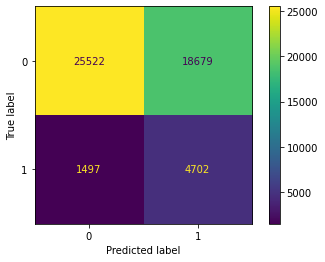

In [148]:
from sklearn.metrics import plot_confusion_matrix, accuracy_score, roc_auc_score

plot_confusion_matrix(clf, x_val, y_val, values_format='d')

In [149]:
print(f'Acc: {accuracy_score(y_val, clf.predict(x_val)):.2f}, roc_auc_score: {roc_auc_score(y_score=clf.predict(x_val), y_true=y_val):.2f} ')

Acc: 0.60, roc_auc_score: 0.67 


### Predict

In [150]:
# pred_df = pd.read_csv(BASE_DIR + '/data/Test Data.csv')
pred_df.head()

,id,income,age,experience,current_job_years,current_house_years,risk_flag,married_married,married_single,house_ownership_norent_noown,house_ownership_owned,house_ownership_rented,car_ownership_no,car_ownership_yes,profession_Analyst,profession_Architect,profession_Artist,profession_Aviator,profession_Chef,profession_Comedian,profession_Consultant,profession_Dentist,profession_Designer,profession_Drafter,profession_Economist,profession_Engineer,profession_Firefighter,profession_Geologist,profession_Lawyer,profession_Librarian,profession_Magistrate,profession_Microbiologist,profession_Official,profession_Physician,profession_Politician,profession_Psychologist,profession_Scientist,profession_Secretary,profession_Statistician,profession_Surgeon,...,city_Tirupati[21][22],city_Tiruppur,city_Tiruvottiyur,city_Tumkur,city_Udaipur,city_Udupi,city_Ujjain,city_Ulhasnagar,city_Uluberia,city_Unnao,city_Vadodara,city_Varanasi,city_Vasai-Virar,city_Vellore,city_Vijayanagaram,city_Vijayawada,city_Visakhapatnam[4],city_Warangal[11][12],city_Yamunanagar,state_Assam,state_Bihar,state_Chandigarh,state_Chhattisgarh,state_Delhi,state_Gujarat,state_Haryana,state_Jharkhand,state_Karnataka,state_Kerala,state_Maharashtra,state_Manipur,state_Mizoram,state_Odisha,state_Puducherry,state_Punjab,state_Rajasthan,state_Sikkim,state_Telangana,state_Tripura,state_Uttarakhand
0,1,7393090,59,19,4,13,NaN,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,1215004,25,5,5,10,NaN,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,3,8901342,50,12,9,14,NaN,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,4,1944421,49,9,3,12,NaN,1,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,13429,25,18,13,11,NaN,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [152]:
# pred_df = pd.get_dummies(pred_df, columns=[ 'married', 'house_ownership', 'car_ownership', 'profession', 'city', 'state' ])

_count = 0
pred_df = pred_df.rename(columns=change_name)
pred_df.head()

,id,income,age,experience,current_job_years,current_house_years,risk_flag,married_married,married_single,house_ownership_norent_noown,house_ownership_owned,house_ownership_rented,car_ownership_no,car_ownership_yes,profession_Analyst,profession_Architect,profession_Artist,profession_Aviator,profession_Chef,profession_Comedian,profession_Consultant,profession_Dentist,profession_Designer,profession_Drafter,profession_Economist,profession_Engineer,profession_Firefighter,profession_Geologist,profession_Lawyer,profession_Librarian,profession_Magistrate,profession_Microbiologist,profession_Official,profession_Physician,profession_Politician,profession_Psychologist,profession_Scientist,profession_Secretary,profession_Statistician,profession_Surgeon,...,city_Tirupati325325,city_Tiruppur,city_Tiruvottiyur,city_Tumkur,city_Udaipur,city_Udupi,city_Ujjain,city_Ulhasnagar,city_Uluberia,city_Unnao,city_Vadodara,city_Varanasi,city_Vasai-Virar,city_Vellore,city_Vijayanagaram,city_Vijayawada,city_Visakhapatnam341,city_Warangal342342,city_Yamunanagar,state_Assam,state_Bihar,state_Chandigarh,state_Chhattisgarh,state_Delhi,state_Gujarat,state_Haryana,state_Jharkhand,state_Karnataka,state_Kerala,state_Maharashtra,state_Manipur,state_Mizoram,state_Odisha,state_Puducherry,state_Punjab,state_Rajasthan,state_Sikkim,state_Telangana,state_Tripura,state_Uttarakhand
0,1,7393090,59,19,4,13,NaN,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,1215004,25,5,5,10,NaN,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,3,8901342,50,12,9,14,NaN,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,4,1944421,49,9,3,12,NaN,1,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,13429,25,18,13,11,NaN,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [157]:
set(pred_df.columns) - set(df.columns), set(pred_df.columns) - set(x_val.columns)

(set(), {'risk_flag'})

In [159]:
predict = pd.DataFrame({
    'id': pred_df['id'],
    'risk_flag': clf.predict(pred_df.drop('risk_flag', axis=1))
})

predict.head()

,id,risk_flag
0,1,1
1,2,1
2,3,1
3,4,0
4,5,1


In [161]:
predict.to_csv(BASE_DIR + '/processed_data/predict.csv', index=False)